In [1]:
# In[1]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import os
import glob  # For finding files

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Notebook Configuration ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
pd.options.display.max_columns = 50
print("✅ Setup Complete: Libraries imported.")

# --- Project Paths (Relative to the `notebooks/` folder) ---
# '../' moves one directory up from 'notebooks/' to the main 'fec-european/' folder.
ROOT_DIR = '../' 
DATASETS_DIR = os.path.join(ROOT_DIR, 'datasets/')
PROCESSED_ARCHIVE_DIR = os.path.join(ROOT_DIR, 'data/processed_by_file/')
MODEL_INPUT_DIR = os.path.join(ROOT_DIR, 'data/model_input/')

# --- Source Data Directories (inside the `datasets` folder) ---
# This is the updated list you provided.
RAW_DATA_DIRECTORIES = [
    'spx_eod_2022q1-ff0r18/',
    'spx_eod_2022q2-bxgzw0/',
    'spx_eod_2022q3-1f2afi/',
    'spx_eod_2022q4-dmme3k/',
    'spx_eod_2023q1-cfph7w/',
    'spx_eod_2023q2-kdxt36/',
    'spx_eod_2023q3-w9b0jk/',
    'spx_eod_2023q4-ai4uc9/'
]

# --- Create output directories if they don't exist ---
os.makedirs(PROCESSED_ARCHIVE_DIR, exist_ok=True)
os.makedirs(MODEL_INPUT_DIR, exist_ok=True)
print(f"✅ Directories configured relative to the project root.")


✅ Setup Complete: Libraries imported.
✅ Directories configured relative to the project root.


In [2]:
# In[2]:
def process_spx_dataframe(df_raw):
    """
    Takes a raw SPX DataFrame and performs all cleaning, reshaping, and feature engineering.
    """
    # --- 1. Reshape from wide to long format ---
    base_cols = ['QUOTE_DATE', 'EXPIRE_DATE', 'UNDERLYING_LAST', 'STRIKE', 'DTE']
    call_cols = {'C_BID': 'bid', 'C_ASK': 'ask', 'C_IV': 'iv', 'C_VOLUME': 'volume', 'C_DELTA': 'delta'}
    put_cols = {'P_BID': 'bid', 'P_ASK': 'ask', 'P_IV': 'iv', 'P_VOLUME': 'volume', 'P_DELTA': 'delta'}

    df_calls = df_raw[base_cols + list(call_cols.keys())].rename(columns=call_cols)
    df_calls['option_type'] = 'C'
    
    df_puts = df_raw[base_cols + list(put_cols.keys())].rename(columns=put_cols)
    df_puts['option_type'] = 'P'

    df_long = pd.concat([df_calls, df_puts], ignore_index=True)

    # --- 2. Initial Cleaning & Price Calculation ---
    df_long['mid_price'] = (df_long['bid'] + df_long['ask']) / 2.0
    df_long.dropna(subset=['iv', 'mid_price', 'DTE', 'STRIKE'], inplace=True)
    df_long = df_long[(df_long['iv'] > 0) & (df_long['mid_price'] > 0.05) & (df_long['DTE'] >= 0)]

    # --- 3. Feature Engineering ---
    df_long['T_years'] = df_long['DTE'] / 365.0
    df_long['moneyness'] = df_long['UNDERLYING_LAST'] / df_long['STRIKE']
    df_long['risk_free_rate'] = 0.03 # Placeholder

    # --- 4. Final Liquidity Filtering ---
    df_final = df_long[
        (df_long['T_years'] > 7/365.0) & (df_long['T_years'] < 1.5) &
        (df_long['moneyness'] > 0.85) & (df_long['moneyness'] < 1.15) &
        (df_long['volume'] >= 1)
    ].copy()
    
    return df_final

print("✅ Data Processing Module defined.")

✅ Data Processing Module defined.


In [3]:
# In[3]:
# Define column names from your data header
columns = [
    'QUOTE_UNIXTIME', 'QUOTE_READTIME', 'QUOTE_DATE', 'QUOTE_TIME_HOURS', 'UNDERLYING_LAST', 'EXPIRE_DATE', 
    'EXPIRE_UNIX', 'DTE', 'C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 
    'C_SIZE', 'C_BID', 'C_ASK', 'STRIKE', 'P_BID', 'P_ASK', 'P_SIZE', 'P_LAST', 'P_DELTA', 'P_GAMMA', 
    'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT'
]

all_raw_files = []
print("Searching for raw data files in specified directories...")
for directory in RAW_DATA_DIRECTORIES:
    # Build the search path inside the ../datasets/ folder
    search_path = os.path.join(DATASETS_DIR, directory, '*.txt')
    found_files = glob.glob(search_path)
    if not found_files:
        print(f"    - ⚠️ No .txt files found in '{search_path}'")
    all_raw_files.extend(found_files)

unique_raw_files = sorted(list(set(all_raw_files)))

print(f"\nFound {len(unique_raw_files)} unique raw files. Starting processing and archiving...\n")

# Loop through each file, process it, and save it to the new mirrored structure
for file_path in unique_raw_files:
    # --- 1. Load a single raw file ---
    df_raw_single = pd.read_csv(file_path, skiprows=1, names=columns, skipinitialspace=True)
    
    for col in ['QUOTE_DATE', 'EXPIRE_DATE']:
        df_raw_single[col] = pd.to_datetime(df_raw_single[col], errors='coerce')
    numeric_cols = [col for col in columns if col not in ['QUOTE_DATE', 'EXPIRE_DATE', 'QUOTE_READTIME', 'C_SIZE', 'P_SIZE']]
    for col in numeric_cols:
        df_raw_single[col] = pd.to_numeric(df_raw_single[col], errors='coerce')

    # --- 2. Process the DataFrame ---
    df_processed = process_spx_dataframe(df_raw_single)
    
    # --- 3. Create the corresponding output path ---
    relative_path = os.path.relpath(file_path, DATASETS_DIR)
    output_path = os.path.join(PROCESSED_ARCHIVE_DIR, relative_path)
    output_path = os.path.splitext(output_path)[0] + '.csv' # Change extension to .csv
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # --- 4. Save the processed file as CSV ---
    if not df_processed.empty:
        df_processed.to_csv(output_path, index=False)
        print(f"    - Processed '{os.path.basename(file_path)}' -> Saved to '{output_path}'")
    else:
        print(f"    - Skipped '{os.path.basename(file_path)}' (no valid data after filtering)")

print("\n✅ All files processed and saved to the mirrored archive directory as CSVs.")


Searching for raw data files in specified directories...

Found 24 unique raw files. Starting processing and archiving...

    - Processed 'spx_eod_202201.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q1-ff0r18/spx_eod_202201.csv'
    - Processed 'spx_eod_202202.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q1-ff0r18/spx_eod_202202.csv'
    - Processed 'spx_eod_202203.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q1-ff0r18/spx_eod_202203.csv'
    - Processed 'spx_eod_202204.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q2-bxgzw0/spx_eod_202204.csv'
    - Processed 'spx_eod_202205.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q2-bxgzw0/spx_eod_202205.csv'
    - Processed 'spx_eod_202206.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q2-bxgzw0/spx_eod_202206.csv'
    - Processed 'spx_eod_202207.txt' -> Saved to '../data/processed_by_file/spx_eod_2022q3-1f2afi/spx_eod_202207.csv'
    - Processed 'spx_eod_202208.txt' -> Saved to '.

Found 24 unique processed files.
Removed 0 duplicate rows.
Removed all rows with iv < 0.05. Remaining rows: 2850174
--- Merged 24 processed files for analysis ---
<class 'pandas.core.frame.DataFrame'>
Index: 2850174 entries, 0 to 2874620
Data columns (total 15 columns):
 #   Column           Dtype         
---  ------           -----         
 0   QUOTE_DATE       datetime64[ns]
 1   EXPIRE_DATE      datetime64[ns]
 2   UNDERLYING_LAST  float64       
 3   STRIKE           float64       
 4   DTE              float64       
 5   bid              float64       
 6   ask              float64       
 7   iv               float64       
 8   volume           float64       
 9   delta            float64       
 10  option_type      object        
 11  mid_price        float64       
 12  T_years          float64       
 13  moneyness        float64       
 14  risk_free_rate   float64       
dtypes: datetime64[ns](2), float64(12), object(1)
memory usage: 347.9+ MB
None

--- Temporal Analysi

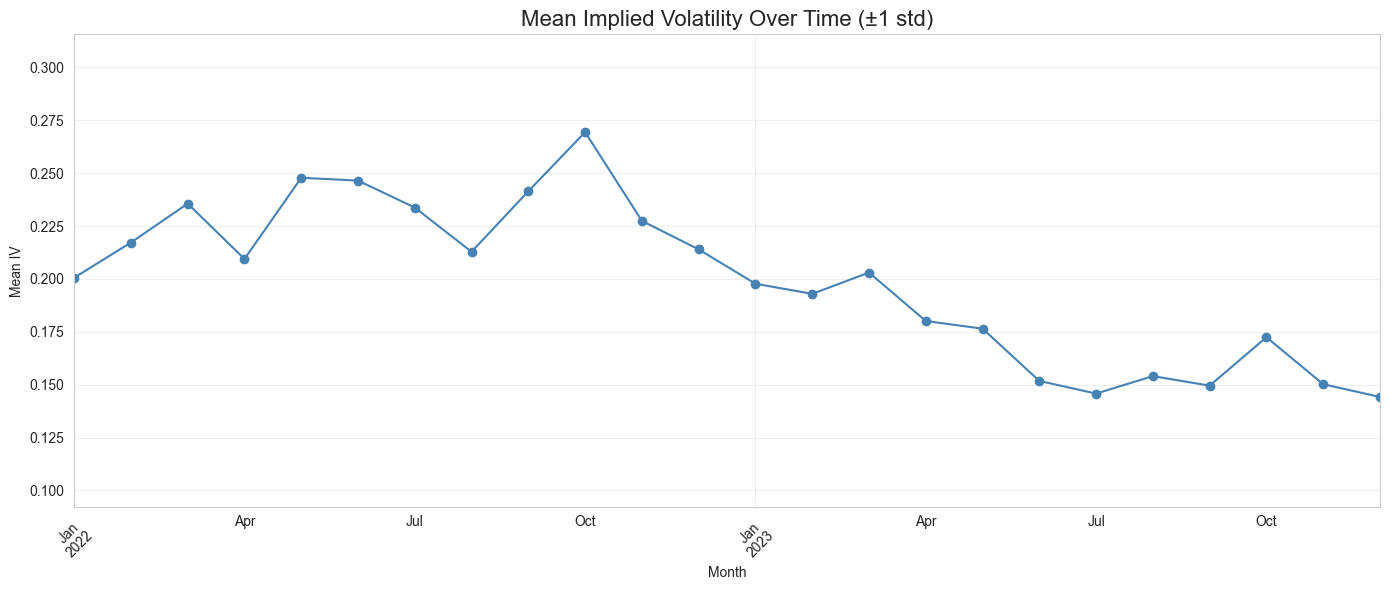

/var/folders/_n/g2t8djzn3vl7rtzcy1dfl8vm0000gn/T/ipykernel_93900/2723436390.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_clean_merged.set_index('QUOTE_DATE')['STRIKE'].resample('M').count().plot(kind='bar')


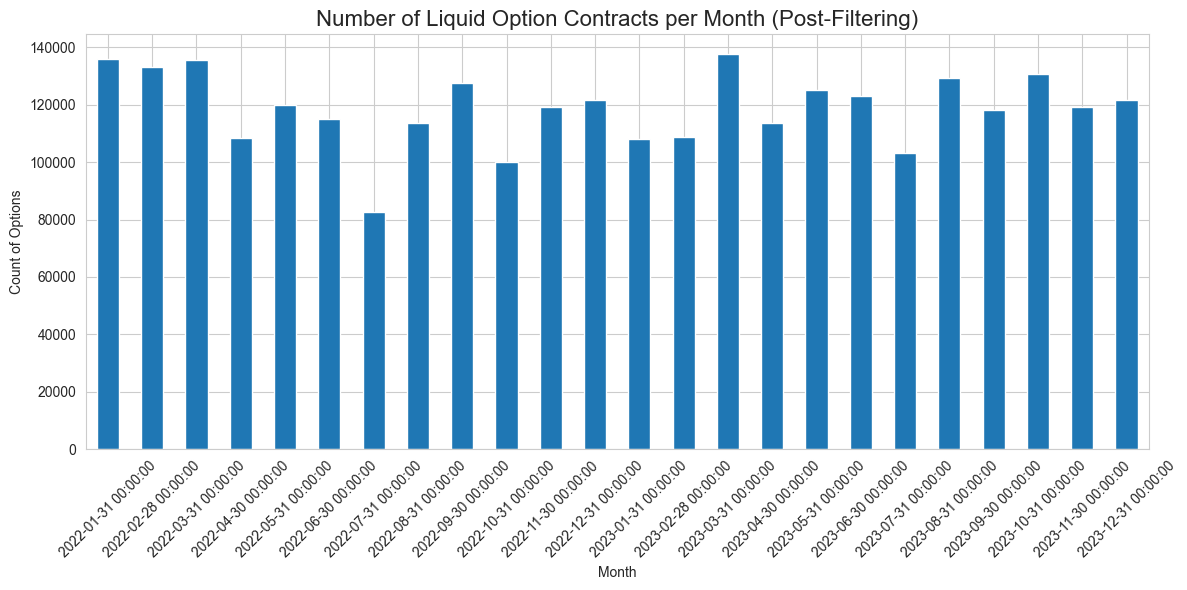


--- Descriptive Statistics of Final Dataset ---
            T_years     moneyness            iv        volume
count  2.850174e+06  2.850174e+06  2.850174e+06  2.850174e+06
mean   2.401152e-01  1.008613e+00  1.983130e-01  4.316934e+01
std    2.683883e-01  6.777911e-02  5.684381e-02  2.513438e+02
min    1.928767e-02  8.500019e-01  5.006000e-02  1.000000e+00
25%    5.742466e-02  9.636669e-01  1.559800e-01  1.000000e+00
50%    1.233973e-01  1.007674e+00  1.963600e-01  4.000000e+00
75%    3.287671e-01  1.056204e+00  2.364200e-01  1.600000e+01
max    1.498740e+00  1.149994e+00  6.921700e-01  7.802600e+04


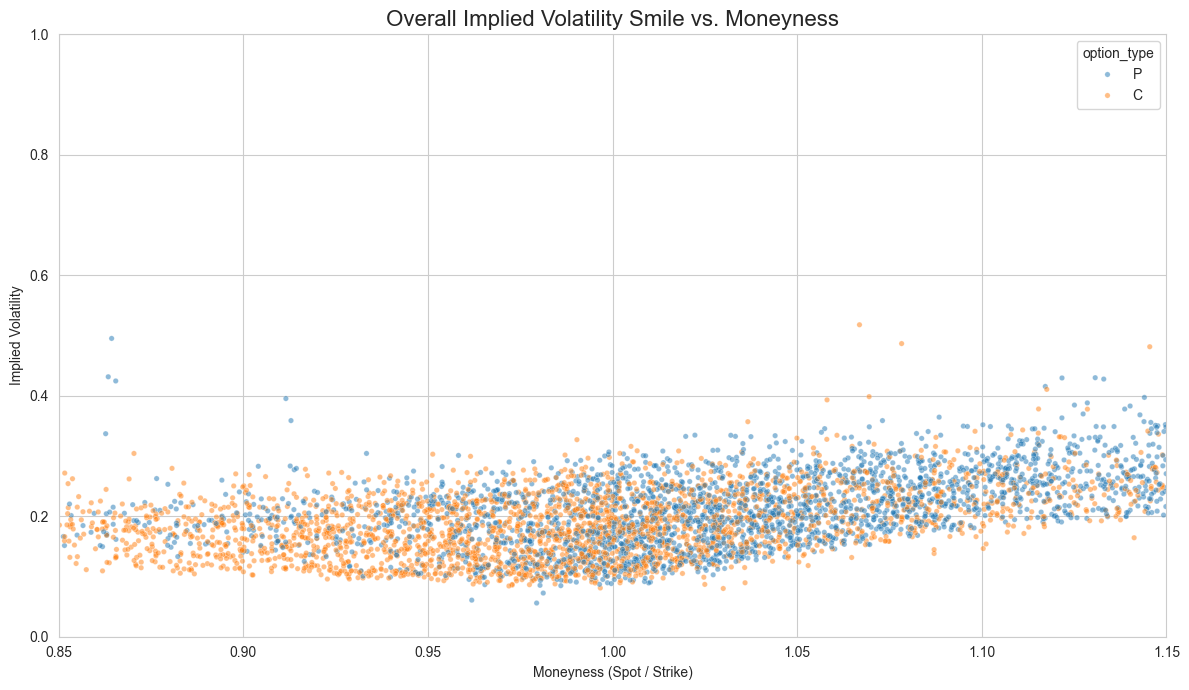


--- Implementing Rolling Window Time-Series Split ---
Date range: 2022-01-03T00:00:00.000000000 to 2023-12-29T00:00:00.000000000
Total unique trading days: 505

--- Split Summary and Data Quality Checks ---

Train Set:
  Date range: 2022-01-03 00:00:00 to 2023-05-24 00:00:00
  Shape: (1982775, 16)
  Percentage of total: 69.6%
  Target stats:
    - min=0.0501, max=0.6922
    - mean=0.2179, std=0.0508
    - median=0.2160
  NaNs in features: 0
  NaNs in target: 0
  Unique target values: 35085
  Option types: {'P': 992382, 'C': 990393}

Validation Set:
  Date range: 2023-05-25 00:00:00 to 2023-09-13 00:00:00
  Shape: (423835, 16)
  Percentage of total: 14.9%
  Target stats:
    - min=0.0501, max=0.5397
    - mean=0.1515, std=0.0429
    - median=0.1438
  NaNs in features: 0
  NaNs in target: 0
  Unique target values: 22935
  Option types: {'C': 219413, 'P': 204422}

Test Set:
  Date range: 2023-09-14 00:00:00 to 2023-12-29 00:00:00
  Shape: (443564, 16)
  Percentage of total: 15.6%
  Targe

/var/folders/_n/g2t8djzn3vl7rtzcy1dfl8vm0000gn/T/ipykernel_93900/2723436390.py:153: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Train', 'Validation', 'Test'])


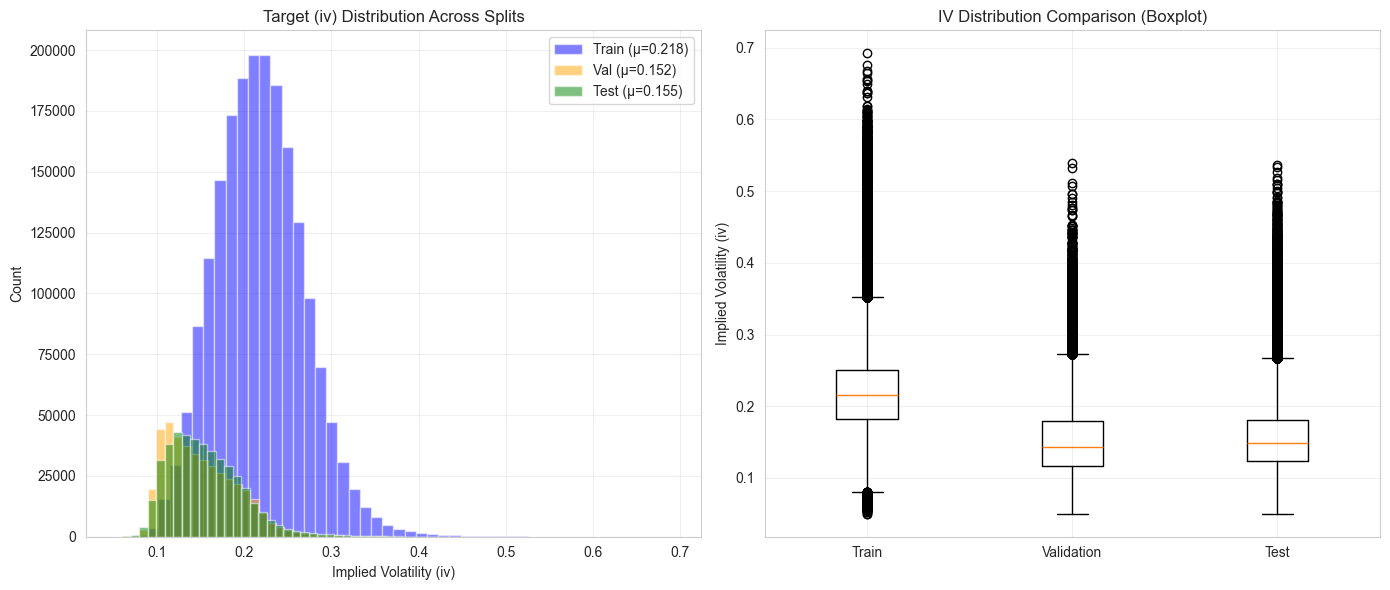

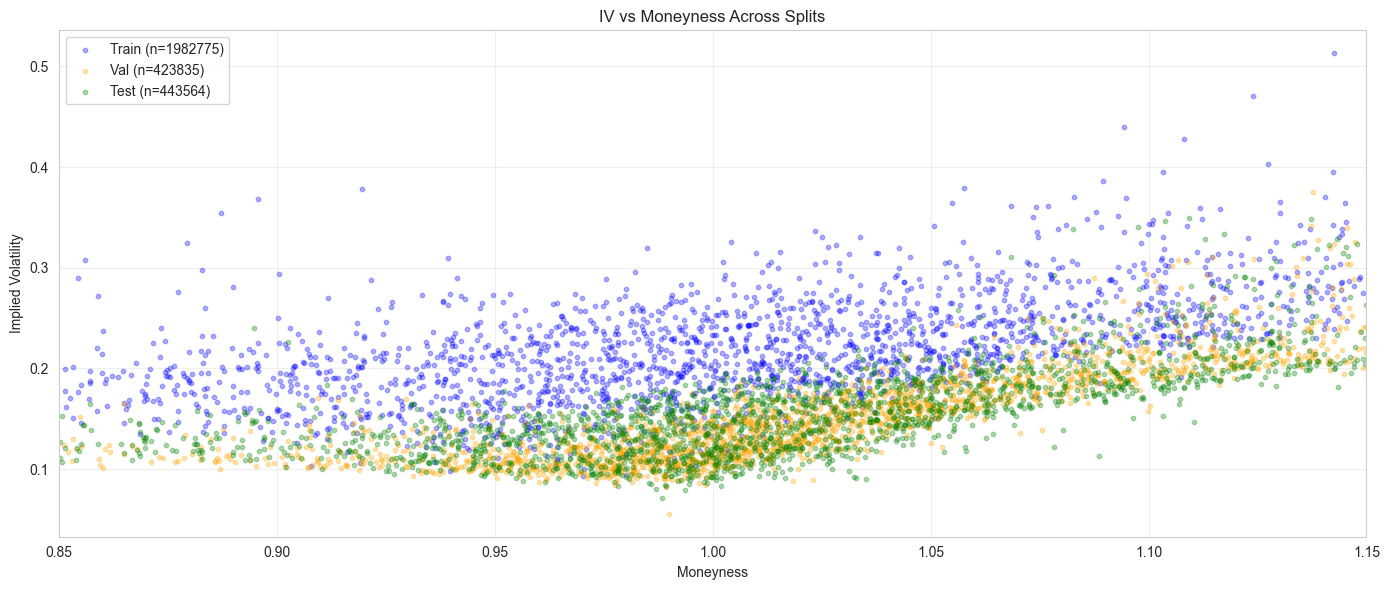


✅ Enhanced splitting complete with diagnostics.


In [4]:
# --- Load all the newly processed .csv files ---
search_pattern_processed = os.path.join(PROCESSED_ARCHIVE_DIR, '**/*.csv')
all_processed_files = glob.glob(search_pattern_processed, recursive=True)

if not all_processed_files:
    print("⚠️ No processed files found to merge for EDA. Please run the previous cell.")
else:
    # Deduplicate files to avoid processing the same data twice
    all_processed_files = sorted(list(set(all_processed_files)))
    print(f"Found {len(all_processed_files)} unique processed files.")
    
    # Load all CSVs into a list of DataFrames
    df_list = [pd.read_csv(f, parse_dates=['QUOTE_DATE', 'EXPIRE_DATE']) for f in all_processed_files]
    df_clean_merged = pd.concat(df_list, ignore_index=True)
    
    # Remove duplicates that might have been created during processing
    initial_rows = len(df_clean_merged)
    df_clean_merged = df_clean_merged.drop_duplicates(
        subset=['QUOTE_DATE', 'STRIKE', 'option_type', 'EXPIRE_DATE'], 
        keep='first'
    )
    print(f"Removed {initial_rows - len(df_clean_merged)} duplicate rows.")
    
    df_clean_merged.sort_values('QUOTE_DATE', inplace=True)
    
    # Remove rows where iv == 0 or iv < 0.05
    df_clean_merged = df_clean_merged[df_clean_merged['iv'] >= 0.05].copy()
    print(f"Removed all rows with iv < 0.05. Remaining rows: {len(df_clean_merged)}")
    
    print(f"--- Merged {len(all_processed_files)} processed files for analysis ---")
    print(df_clean_merged.info())

    # --- Enhanced EDA: Check for temporal patterns in IV ---
    print("\n--- Temporal Analysis of Implied Volatility ---")
    df_clean_merged['year_month'] = df_clean_merged['QUOTE_DATE'].dt.to_period('M')
    monthly_iv_stats = df_clean_merged.groupby('year_month')['iv'].agg(['mean', 'std', 'count'])
    print(monthly_iv_stats)
    
    # Visualize IV over time
    plt.figure(figsize=(14, 6))
    monthly_iv_stats['mean'].plot(kind='line', marker='o', color='steelblue')
    plt.fill_between(range(len(monthly_iv_stats)), 
                     monthly_iv_stats['mean'] - monthly_iv_stats['std'],
                     monthly_iv_stats['mean'] + monthly_iv_stats['std'],
                     alpha=0.2)
    plt.title('Mean Implied Volatility Over Time (±1 std)', fontsize=16)
    plt.ylabel('Mean IV')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Volume per Month ---
    plt.figure(figsize=(12, 6))
    df_clean_merged.set_index('QUOTE_DATE')['STRIKE'].resample('M').count().plot(kind='bar')
    plt.title('Number of Liquid Option Contracts per Month (Post-Filtering)', fontsize=16)
    plt.ylabel('Count of Options')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n--- Descriptive Statistics of Final Dataset ---")
    print(df_clean_merged[['T_years', 'moneyness', 'iv', 'volume']].describe())
    
    # --- IV Smile on the full dataset ---
    plt.figure(figsize=(12, 7))
    sample_size = min(5000, len(df_clean_merged))
    sns.scatterplot(data=df_clean_merged.sample(n=sample_size), 
                    x='moneyness', y='iv', hue='option_type', alpha=0.5, s=15)
    plt.title('Overall Implied Volatility Smile vs. Moneyness', fontsize=16)
    plt.xlabel('Moneyness (Spot / Strike)')
    plt.ylabel('Implied Volatility')
    plt.xlim(0.85, 1.15)
    plt.ylim(0, 1.0)
    plt.tight_layout()
    plt.show()

    # --- IMPROVED SPLITTING STRATEGY ---
    # Option 1: Rolling Window Split (preserves temporal ordering)
    # This creates train/val/test sets that each span the full time period
    print("\n--- Implementing Rolling Window Time-Series Split ---")
    
    df_sorted = df_clean_merged.sort_values('QUOTE_DATE').reset_index(drop=True)
    
    # Get unique dates
    unique_dates = df_sorted['QUOTE_DATE'].unique()
    unique_dates = pd.to_datetime(unique_dates)
    unique_dates = np.sort(unique_dates)
    
    print(f"Date range: {unique_dates[0]} to {unique_dates[-1]}")
    print(f"Total unique trading days: {len(unique_dates)}")
    
    # Calculate split points by date (not by rows)
    n_dates = len(unique_dates)
    train_date_cutoff = unique_dates[int(n_dates * 0.70)]
    val_date_cutoff = unique_dates[int(n_dates * 0.85)]
    
    # Split based on dates
    df_train = df_sorted[df_sorted['QUOTE_DATE'] <= train_date_cutoff].copy()
    df_val = df_sorted[(df_sorted['QUOTE_DATE'] > train_date_cutoff) & 
                       (df_sorted['QUOTE_DATE'] <= val_date_cutoff)].copy()
    df_test = df_sorted[df_sorted['QUOTE_DATE'] > val_date_cutoff].copy()
    
    features = ['T_years', 'moneyness', 'risk_free_rate']
    target = 'iv'

    # --- Check Split Summary and Data Quality ---
    print("\n--- Split Summary and Data Quality Checks ---")
    for split_name, split_df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
        print(f"\n{split_name} Set:")
        print(f"  Date range: {split_df['QUOTE_DATE'].min()} to {split_df['QUOTE_DATE'].max()}")
        print(f"  Shape: {split_df.shape}")
        print(f"  Percentage of total: {len(split_df)/len(df_sorted)*100:.1f}%")
        print(f"  Target stats:")
        print(f"    - min={split_df[target].min():.4f}, max={split_df[target].max():.4f}")
        print(f"    - mean={split_df[target].mean():.4f}, std={split_df[target].std():.4f}")
        print(f"    - median={split_df[target].median():.4f}")
        print(f"  NaNs in features: {split_df[features].isna().sum().sum()}")
        print(f"  NaNs in target: {split_df[target].isna().sum()}")
        print(f"  Unique target values: {split_df[target].nunique()}")
        print(f"  Option types: {split_df['option_type'].value_counts().to_dict()}")

    # Check for distribution shift
    print("\n--- Distribution Shift Analysis ---")
    train_mean, val_mean, test_mean = df_train[target].mean(), df_val[target].mean(), df_test[target].mean()
    print(f"Mean IV - Train: {train_mean:.4f}, Val: {val_mean:.4f}, Test: {test_mean:.4f}")
    print(f"Relative shift - Val vs Train: {(val_mean/train_mean - 1)*100:.1f}%")
    print(f"Relative shift - Test vs Train: {(test_mean/train_mean - 1)*100:.1f}%")
    
    if abs(val_mean/train_mean - 1) > 0.15 or abs(test_mean/train_mean - 1) > 0.15:
        print("⚠️ WARNING: Significant distribution shift detected (>15%)!")
        print("   Consider normalizing IV by period or using a different split strategy.")
    else:
        print("✅ Distribution shift is within acceptable range.")

    # Plot target distribution for each split
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_train[target], bins=50, alpha=0.5, label=f'Train (μ={train_mean:.3f})', color='blue')
    plt.hist(df_val[target], bins=50, alpha=0.5, label=f'Val (μ={val_mean:.3f})', color='orange')
    plt.hist(df_test[target], bins=50, alpha=0.5, label=f'Test (μ={test_mean:.3f})', color='green')
    plt.legend()
    plt.title('Target (iv) Distribution Across Splits')
    plt.xlabel('Implied Volatility (iv)')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    box_data = [df_train[target], df_val[target], df_test[target]]
    plt.boxplot(box_data, labels=['Train', 'Validation', 'Test'])
    plt.ylabel('Implied Volatility (iv)')
    plt.title('IV Distribution Comparison (Boxplot)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional diagnostic: IV by moneyness across splits
    plt.figure(figsize=(14, 6))
    for split_name, split_df, color in [('Train', df_train, 'blue'), 
                                         ('Val', df_val, 'orange'), 
                                         ('Test', df_test, 'green')]:
        sample = split_df.sample(n=min(2000, len(split_df)))
        plt.scatter(sample['moneyness'], sample[target], alpha=0.3, s=10, 
                   label=f'{split_name} (n={len(split_df)})', color=color)
    plt.xlabel('Moneyness')
    plt.ylabel('Implied Volatility')
    plt.title('IV vs Moneyness Across Splits')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0.85, 1.15)
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Enhanced splitting complete with diagnostics.")



In [5]:
# In[5]: Improved Save Function with Normalization Option
def split_and_save_modeling_data(df_train, df_val, df_test, features, target, output_dir, 
                                  normalize_by_date=False):
    """
    Saves the already-split data for modeling with optional normalization.
    
    Parameters:
    -----------
    normalize_by_date : bool
        If True, normalizes IV within each date to reduce temporal drift effects
    """
    print("\n--- Saving Final Modeling Datasets ---")
    
    if normalize_by_date:
        print("Applying date-wise normalization to reduce temporal drift...")
        for split_df in [df_train, df_val, df_test]:
            # Group by date and normalize IV
            split_df['iv_normalized'] = split_df.groupby('QUOTE_DATE')[target].transform(
                lambda x: (x - x.mean()) / (x.std() + 1e-8)
            )
        target_to_use = 'iv_normalized'
        print("✅ Using normalized IV as target.")
    else:
        target_to_use = target
        print("Using raw IV as target.")
    
    # Create separate objects for features and target
    X_train, y_train = df_train[features], df_train[target_to_use]
    X_val, y_val = df_val[features], df_val[target_to_use]
    X_test, y_test = df_test[features], df_test[target_to_use]
    
    # Also save metadata for reconstruction
    for split_name, split_df in [('train', df_train), ('val', df_val), ('test', df_test)]:
        split_df[['QUOTE_DATE', 'EXPIRE_DATE', 'STRIKE', 'option_type', target]].to_csv(
            os.path.join(output_dir, f'{split_name}_metadata.csv'), index=False
        )
    
    # Save feature and target files
    for name, data in {'X_train': X_train, 'y_train': y_train, 
                       'X_val': X_val, 'y_val': y_val, 
                       'X_test': X_test, 'y_test': y_test}.items():
        filepath = os.path.join(output_dir, f'{name}.csv')
        data.to_csv(filepath, index=False)
        print(f"  Saved: {filepath}")
    
    print(f"\n✅ Modeling datasets saved to '{output_dir}'")
    print(f"   Train: {len(X_train)} samples")
    print(f"   Val: {len(X_val)} samples")
    print(f"   Test: {len(X_test)} samples")
    return X_train, y_train, X_val, y_val, X_test, y_test


# --- Execute final save ---
if 'df_train' in locals() and not df_train.empty:
    feature_cols = ['T_years', 'moneyness', 'risk_free_rate']
    target_col = 'iv'
    
    # Choose normalization strategy based on your analysis
    # Set to True if you saw significant distribution shift (>15%)
    use_normalization = (abs(df_val[target_col].mean()/df_train[target_col].mean() - 1) > 0.15)
    
    if use_normalization:
        print("\n⚠️ Significant distribution shift detected. Applying normalization.")
    
    split_and_save_modeling_data(
        df_train, df_val, df_test, 
        feature_cols, target_col, MODEL_INPUT_DIR,
        normalize_by_date=use_normalization
    )
else:
    print("⚠️ Skipping final save because splits are not available.")


⚠️ Significant distribution shift detected. Applying normalization.

--- Saving Final Modeling Datasets ---
Applying date-wise normalization to reduce temporal drift...
✅ Using normalized IV as target.
  Saved: ../data/model_input/X_train.csv
  Saved: ../data/model_input/y_train.csv
  Saved: ../data/model_input/X_val.csv
  Saved: ../data/model_input/y_val.csv
  Saved: ../data/model_input/X_test.csv
  Saved: ../data/model_input/y_test.csv

✅ Modeling datasets saved to '../data/model_input/'
   Train: 1982775 samples
   Val: 423835 samples
   Test: 443564 samples



--- Split Summary and Data Quality Checks ---

Train Set:
  Shape: (1982775, 17)
  Features: ['T_years', 'moneyness', 'risk_free_rate']
  Target: iv
  Target stats: min=0.0501, max=0.6922, mean=0.2179, std=0.0508
  NaNs in features: 0
  NaNs in target: 0
  Unique target values: 35085

Validation Set:
  Shape: (423835, 17)
  Features: ['T_years', 'moneyness', 'risk_free_rate']
  Target: iv
  Target stats: min=0.0501, max=0.5397, mean=0.1515, std=0.0429
  NaNs in features: 0
  NaNs in target: 0
  Unique target values: 22935

Test Set:
  Shape: (443564, 17)
  Features: ['T_years', 'moneyness', 'risk_free_rate']
  Target: iv
  Target stats: min=0.0502, max=0.5369, mean=0.1555, std=0.0428
  NaNs in features: 0
  NaNs in target: 0
  Unique target values: 24283


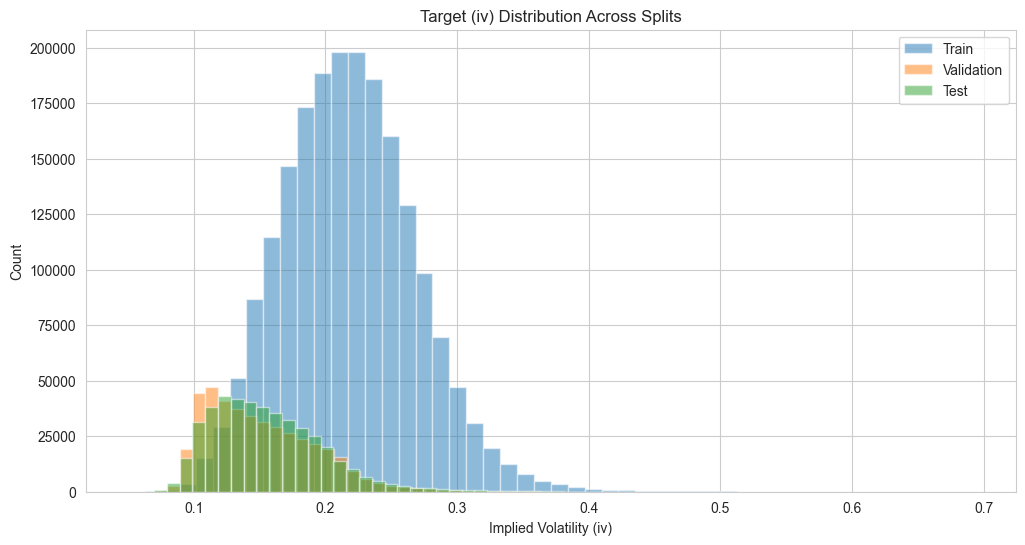


--- Data Quality Checks ---
Train shape: (1982775, 17)
Validation shape: (423835, 17)
Test shape: (443564, 17)
Train: NaNs in features: 0, NaNs in target: 0
Validation: NaNs in features: 0, NaNs in target: 0
Test: NaNs in features: 0, NaNs in target: 0
Train: Target min=0.0501, max=0.6922, std=0.050786
Validation: Target min=0.0501, max=0.5397, std=0.042920
Test: Target min=0.0502, max=0.5369, std=0.042835

--- Data Quality Checks Complete ---


In [6]:
# In[6]:
# --- Check Split Summary and Data Quality ---
print("\n--- Split Summary and Data Quality Checks ---")

for split_name, split_df in zip(
    ['Train', 'Validation', 'Test'],
    [df_train, df_val, df_test]
):
    print(f"\n{split_name} Set:")
    print(f"  Shape: {split_df.shape}")
    print(f"  Features: {features}")
    print(f"  Target: {target}")
    print(f"  Target stats: min={split_df[target].min():.4f}, max={split_df[target].max():.4f}, mean={split_df[target].mean():.4f}, std={split_df[target].std():.4f}")
    print(f"  NaNs in features: {split_df[features].isna().sum().sum()}")
    print(f"  NaNs in target: {split_df[target].isna().sum()}")
    print(f"  Unique target values: {split_df[target].nunique()}")

# Optional: Plot target distribution for each split
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.hist(df_train[target], bins=50, alpha=0.5, label='Train')
plt.hist(df_val[target], bins=50, alpha=0.5, label='Validation')
plt.hist(df_test[target], bins=50, alpha=0.5, label='Test')
plt.legend()
plt.title('Target (iv) Distribution Across Splits')
plt.xlabel('Implied Volatility (iv)')
plt.ylabel('Count')
plt.show()

# --- Data Quality Checks After Filtering and Splitting ---
print("\n--- Data Quality Checks ---")

# Check for empty splits
split_shapes = {
    'Train': df_train.shape,
    'Validation': df_val.shape,
    'Test': df_test.shape
}
for split, shape in split_shapes.items():
    print(f"{split} shape: {shape}")
    if shape[0] == 0:
        print(f"⚠️ {split} split is empty!")

# Check for NaNs in features and target
for split_name, split_df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
    nan_features = split_df[features].isna().sum().sum()
    nan_target = split_df[target].isna().sum()
    print(f"{split_name}: NaNs in features: {nan_features}, NaNs in target: {nan_target}")
    if nan_features > 0 or nan_target > 0:
        print(f"⚠️ {split_name} split contains NaNs!")

# Check for constant target (low variance)
for split_name, split_df in zip(['Train', 'Validation', 'Test'], [df_train, df_val, df_test]):
    target_std = split_df[target].std()
    target_min = split_df[target].min()
    target_max = split_df[target].max()
    print(f"{split_name}: Target min={target_min:.4f}, max={target_max:.4f}, std={target_std:.6f}")
    if target_std < 1e-4:
        print(f"⚠️ {split_name} target is nearly constant!")

print("\n--- Data Quality Checks Complete ---")